### Install libraries

In [ ]:
# !pip install -r ../../dev-requirements.txt

### Set up variables for MLFlow

In [ ]:
import os
os.environ["MLFLOW_TRACKING_URI"]="http://localhost:5001"

### Load Data

In [ ]:
import pandas as pd
import os

folder = os.path.join("../../airflow/assets/binance_1d")
dfs = []
for file in os.listdir(folder):
    if file.endswith(".csv"):
        dfs.append(pd.read_csv(os.path.join(folder, file), skiprows=1, parse_dates=['Date']))
print(dfs.__len__())

#### Merge all data into one dataframe

In [ ]:
import pandas as pd

# Step 1: Convert "date" column to datetime in all dataframes
for df in dfs:
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors="coerce")

# Step 2: Find the oldest and newest dates across all dataframes
all_dates = [df['Date'] for df in dfs]
all_dates_flat = [date for sublist in all_dates for date in sublist if not pd.isnull(date)]

oldest_date = '2019-01-01'
newest_date = max(all_dates_flat)

# Step 3: Create a new dataframe with the date range
date_range = pd.date_range(start=oldest_date, end=newest_date, freq='D')  # Daily frequency
merged_df = pd.DataFrame({'Date': date_range})

# Step 4: Add "close" and "Volume USDT" columns from each dataframe to the merged_df using list comprehension
for df in dfs:
    try:
        ticker = df['Symbol'].iloc[0]  # Assuming each dataframe has a "symbol" column
        close_col_name = f'close_{ticker}'
        volume_col_name = f'Volume USDT_{ticker}'  # Replace with the actual column name if it's different in your data

        df = df.set_index('Date').sort_index()

        # Create DataFrames with the "date" and "close" columns
        close_data = df[df.index.isin(date_range)][['Close']]
        close_data.rename(columns={'Close': close_col_name}, inplace=True)

        # Merge the "close_data" into the "merged_df"
        merged_df = pd.merge(merged_df, close_data, left_on='Date', right_index=True, how='left')

        # Add the "Volume USDT" column to the merged_df (replace 'Volume USDT' with the actual column name if it's different)
        # merged_df[volume_col_name] = df['Volume USDT']

    except ValueError as e:
        print(f'Error on coin {ticker}: {e}')


# print number of columns -1 of merged_df
print(merged_df.columns.__len__()-1)

### Clustering Analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from fastdtw import fastdtw
from tqdm import tqdm
import mlflow
import mlflow.sklearn
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids


# Create a custom Min-Max scaling function
def custom_min_max_scaling(column):
    min_val = column.min()
    max_val = column.max()
    scaled_column = (column - min_val) / (max_val - min_val)
    return scaled_column


def preprocess_data(
    merged_df,
    scale_data=None,
    percentage_change=False
):
    time_series_data = merged_df.copy()

    # Select the time series columns for clustering and exclude 'date' column
    time_series_data = time_series_data.iloc[:, 1:].values

    # Optionally calculate percentage change
    if percentage_change:
        time_series_data = np.diff(time_series_data, axis=0) / time_series_data[:-1, :]

    time_series_data = time_series_data.T  # Transpose the data to have time series in rows

    # Optionally scale data (e.g., min-max scaling or log transformation)
    if scale_data == "custom_min_max":
        time_series_data = np.array([custom_min_max_scaling(col) for col in time_series_data])
    elif scale_data == "log":
        time_series_data = np.log(time_series_data)

    return time_series_data

def do_clustering(
    merged_df,
    cluster_range=range(2, 8),
    clustering_algorithm="KMeans",
    scale_data=None,
    percentage_change=False
):
    experiment_name = f"Clustering Binance 1D"
    mlflow.set_experiment(experiment_name)

    time_series_data = preprocess_data(merged_df, scale_data, percentage_change)

    # Rest of your clustering code
    distances = None
    # Initialize an empty array to store the distances
    distances = np.zeros((time_series_data.shape[0], time_series_data.shape[0]))
    # Calculate DTW distances between time series columns with progress tracking
    for i in tqdm(range(time_series_data.shape[0]), desc="Calculating DTW Distances"):
        for j in range(i, time_series_data.shape[0]):
            distance, _ = fastdtw(time_series_data[i], time_series_data[j])
            distances[i, j] = distance
            distances[j, i] = distance

    # Silhouette Score vs. Cluster Count
    silhouette_scores = []
    inertia_scores = []

    # Iterate through different cluster counts
    for n_clusters in cluster_range:

        with mlflow.start_run():

            # Log parameters to MLflow
            mlflow.log_params({
              "N_clusters": str(n_clusters),
              "Clustering_Algorithm": clustering_algorithm,
              "Scale_Data": scale_data,
              "Percentage_Change": percentage_change
            })

            print(f"Running experiment for {n_clusters} clusters...")

            if clustering_algorithm == "KMeans":
                # Perform K-Means clustering with DTW distances
                kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(distances)

                # Get cluster labels
                labels = kmeans.labels_
                inertia_score = kmeans.inertia_

                print("K-Means clustering completed.")

            elif clustering_algorithm == "KMedoids":
                # Perform K-Medoids clustering with DTW distances
                kmedoids = KMedoids(n_clusters=n_clusters, metric="precomputed", random_state=0).fit(distances)

                # Get cluster labels
                labels = kmedoids.labels_
                inertia_score = kmedoids.inertia_

                print("K-Medoids clustering completed.")

            mlflow.log_params({
                "Distance_Matrix_Shape": distances.shape,
                "Cluster_Labels": [pair for pair in zip(merged_df.columns[1:], labels.tolist())]
            })

            print("Clustering results logged to MLflow.")

            silhouette = silhouette_score(distances, labels, metric="precomputed")

            silhouette_scores.append(silhouette)
            inertia_scores.append(inertia_score)

            mlflow.log_metrics({
                "Silhouette_Score": silhouette,
                "Inertia_Score": inertia_score
            })

            # Define a color palette for plotting
            palette = sns.color_palette("husl", len(time_series_data))

            # Visualize the clustered time series using Seaborn
            num_rows = n_clusters
            num_cols = 1
            fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))

            for cluster_id in range(n_clusters):
                ax = axes[cluster_id] if num_rows > 1 else axes
                for series_idx, label in enumerate(labels):
                    if label == cluster_id:
                        series_name = merged_df.columns[series_idx + 1]  # Get the column name (series name)
                        sns.lineplot(data=time_series_data[series_idx], color=palette[series_idx], label=series_name, ax=ax)

                ax.annotate(f"Inertia: {inertia_score:.2f}", xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10)
                ax.annotate(f"Silhouette: {silhouette:.2f}", xy=(0.05, 0.75), xycoords='axes fraction', fontsize=10)

                ax.set_title(f"Cluster {cluster_id + 1}")
                ax.legend(loc='upper right')  # Add legends for series in the cluster

            plt.tight_layout()

            # Save the plot to a file and log it to MLflow
            plot_path = f"cluster_plots_{n_clusters}_clusters.png"
            plt.savefig(plot_path)
            mlflow.log_artifact(plot_path)

            print("Cluster visualization plot saved and logged to MLflow.")

            plt.show()

    with mlflow.start_run(run_name="Scores_logging"):

        # Log parameters to MLflow
        mlflow.log_param("N_clusters", str(n_clusters))
        mlflow.log_param("Clustering_Algorithm", clustering_algorithm)
        mlflow.log_param("Scale_Data", scale_data)
        mlflow.log_param("Percentage_Change", percentage_change)


        # Log the lists of Silhouette and Inertia scores
        mlflow.log_param("Silhouette_Scores", silhouette_scores)
        mlflow.log_param("Inertia_Scores", inertia_scores)

        # Silhouette Score vs. Cluster Count plot
        plt.figure(figsize=(8, 4))
        plt.plot(cluster_range, silhouette_scores, marker='o')
        plt.title("Silhouette Score vs. Cluster Count")
        plt.xlabel("Cluster Count")
        plt.ylabel("Silhouette Score")
        plt.tight_layout()
        plt.savefig("silhouette_scores_plot.png")
        mlflow.log_artifact("silhouette_scores_plot.png")

        # Inertia Score vs. Cluster Count plot
        plt.figure(figsize=(8, 4))
        plt.plot(cluster_range, inertia_scores, marker='o')
        plt.title("Inertia Score vs. Cluster Count")
        plt.xlabel("Cluster Count")
        plt.ylabel("Inertia Score")
        plt.tight_layout()
        plt.savefig("inertia_scores_plot.png")
        mlflow.log_artifact("inertia_scores_plot.png")


#### Clustering Analysis (on Raw Series)

KeyboardInterrupt: 

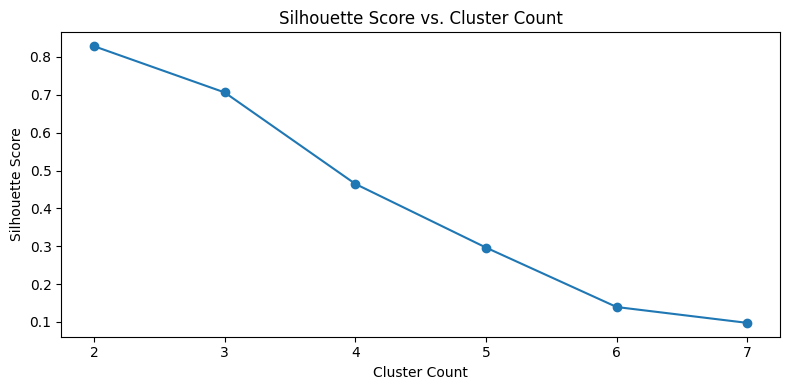

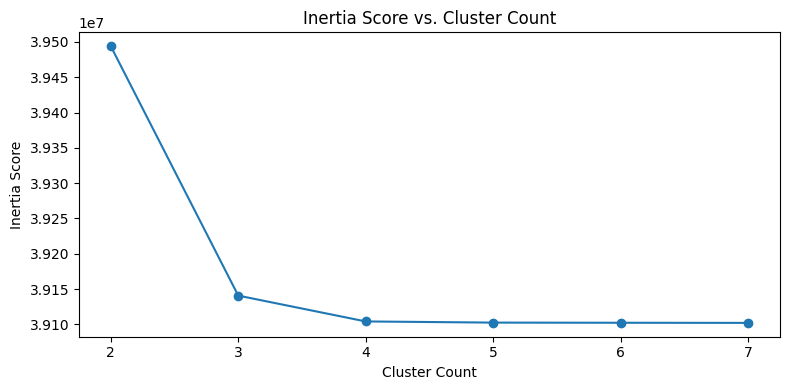

In [6]:
# Experiment 1: Raw Data
do_clustering(
    merged_df,
    clustering_algorithm="KMeans",
    scale_data=None,
)
do_clustering(
    merged_df,
    clustering_algorithm="KMedoids",
    scale_data=None,
)


# Experiment 2: Min-Max Scaling
do_clustering(
    merged_df,
    clustering_algorithm="KMeans",
    scale_data="custom_min_max",
)

do_clustering(
    merged_df,
    clustering_algorithm="KMedoids",
    scale_data="custom_min_max",
)


# Experiment 3: Log scaling
do_clustering(
    merged_df,
    clustering_algorithm="KMeans",
    scale_data="log",
)

do_clustering(
    merged_df,
    clustering_algorithm="KMedoids",
    scale_data="log",
)


# Experiment 4: Percentage change
do_clustering(
    merged_df,
    clustering_algorithm="KMeans",
    percentage_change=True
)

do_clustering(
    merged_df,
    clustering_algorithm="KMedoids",
    percentage_change=True
)